In [69]:
from asyncio.windows_events import INFINITE

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from networkx.classes import non_edges
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os 
from PIL import Image
from torchvision import models
from torchvision.models import ResNet18_Weights
from sklearn.model_selection import train_test_split
import torchvision.models as models
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import math


In [56]:
df=pd.read_csv('seatbelt_detections.csv')

In [57]:
df.head()

,Image_id,All Wearing Seatbelts,No Seatbelt
0,_IEqzL0ONE_jpg.rf.dff7cb585978d2716a552bbe0ecd...,0,1
1,04-09-35_jpg.rf.a4d05d1557943070888c54e7a7ce3c...,0,1
2,04-31-24_jpg.rf.34f9c5387cfa1a03413c7f656d4bed...,0,1
3,04-52-15_jpg.rf.3cdb0b59f48f61c7b46a4f25eed02c...,0,1
4,04-59-59_jpg.rf.7c4e579e297e730b5a5b3bed029d63...,0,1


In [58]:
def check_image_files(df, image_folder):
    """
    Checks if all the images referenced in the 'image_id' column of a DataFrame are present in the specified folder.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame containing the 'image_id' column.
    image_folder (str): The path to the folder containing the images.
    
    Returns:
    list: A list of image IDs that are not found in the folder.
    """
    missing_images = []
    
    for image_id in df['Image_id']:
        image_path = os.path.join(image_folder, image_id)
        if not os.path.isfile(image_path):
            missing_images.append(image_id)
    
    return missing_images

image_folder = 'test_images'

missing_images = check_image_files(df, image_folder)

if missing_images:
    print(f"The following images are missing from the folder: {', '.join(missing_images)}")
    print(len(missing_images))
else:
    print("All images are present in the folder.")

All images are present in the folder.


In [60]:
def determine_class(row):
    if row['All Wearing Seatbelts'] == 1:
        return 'All Wearing Seatbelts'
    elif row['No Seatbelt'] == 1:
        return 'No Seatbelt'
    return 'Unknown'


df['Class'] = df.apply(determine_class, axis=1)


In [61]:
df["Class"].unique()

array(['No Seatbelt', 'All Wearing Seatbelts'], dtype=object)

In [62]:
class_distribution = df['Class'].value_counts()
print(class_distribution)


Class
All Wearing Seatbelts    3289
No Seatbelt              2154
Name: count, dtype: int64


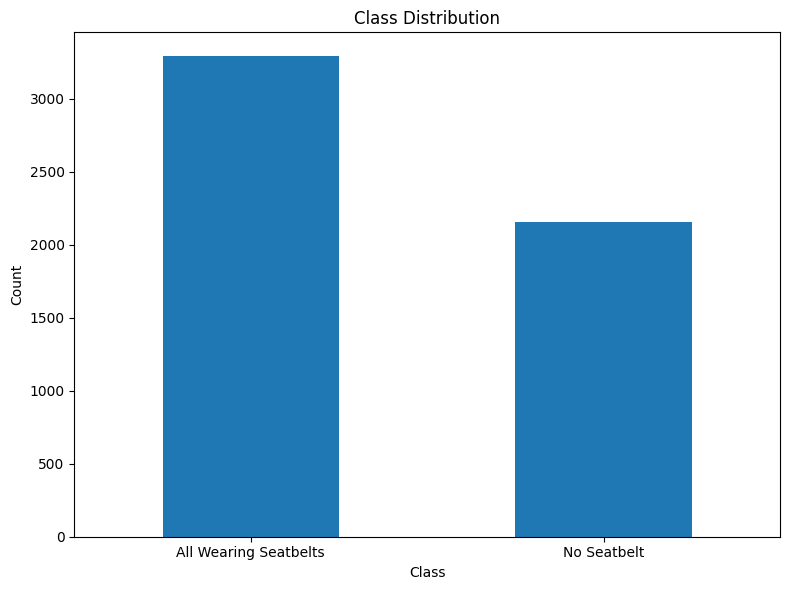

In [63]:


class_distribution = df['Class'].value_counts()


plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [64]:

small_classes = df['Class'].value_counts()[df['Class'].value_counts() < 5].index
main_df = df[~df['Class'].isin(small_classes)]
_= df[df['Class'].isin(small_classes)]


train_df, valid_df = train_test_split(
    main_df, 
    test_size=0.1, 
    stratify=main_df['Class'],
    random_state=420
)


print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")



Train set size: 4898
Validation set size: 545


In [65]:

label_mapping = {'All Wearing Seatbelts': 0, 'No Seatbelt': 1}
train_df['label'] = train_df.iloc[:, 1].map(label_mapping)
valid_df['label'] = valid_df.iloc[:, 1].map(label_mapping)

train_df = pd.get_dummies(train_df, columns=['label'], prefix='', prefix_sep='')
valid_df = pd.get_dummies(valid_df, columns=['label'], prefix='', prefix_sep='')


In [86]:


class ImageDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name)

        
        if self.transform is None:
            resize_transform = transforms.Resize((224, 224))
            image = resize_transform(image)

        
        if self.transform:
            image = self.transform(image)

        label = self.df.iloc[idx, 1]

        return image, label



resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageDataset(train_df, 'test_images', transform=resnet_transform)
val_dataset = ImageDataset(valid_df, 'test_images', transform=resnet_transform)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [87]:

train_size = len(train_dataset)
val_size = len(val_dataset)

print(f"Train set size: {train_size}")
print(f"Validation set size: {val_size}")


Train set size: 4898
Validation set size: 545


In [88]:
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.to('cuda')


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
#optimizer= optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)


In [89]:
def save_checkpoint(state,filename='ResNet18.pth.tar'):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [90]:
EPOCHS = 8
best_val_loss = math.inf  # Set initial best validation loss to infinity

for epoch in range(EPOCHS):
    model.train()  
    losses = []
    running_loss = 0.0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Calculate average training loss
    avg_loss = sum(losses) / len(losses)
    scheduler.step(avg_loss)  

    # Validation phase
    model.eval()  
    val_losses = []
    with torch.no_grad():  
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to('cuda'), val_labels.to('cuda')
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_losses.append(val_loss.item())
    
    # Calculate average validation loss
    val_avg_loss = sum(val_losses) / len(val_losses)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Training Loss: {avg_loss:.4f}, Validation Loss: {val_avg_loss:.4f}')
    
    # Save the model if it has the lowest validation loss
    if val_avg_loss < best_val_loss:
        best_val_loss = val_avg_loss
        checkpoint = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        save_checkpoint(checkpoint)
        print(f'Model saved at epoch {epoch + 1} with Validation Loss: {val_avg_loss:.4f}')

print('Training Done')


Epoch [1/8], Training Loss: 0.4528, Validation Loss: 0.3443
=> Saving checkpoint
Model saved at epoch 1 with Validation Loss: 0.3443
Epoch [2/8], Training Loss: 0.2934, Validation Loss: 0.2781
=> Saving checkpoint
Model saved at epoch 2 with Validation Loss: 0.2781
Epoch [3/8], Training Loss: 0.1954, Validation Loss: 0.2389
=> Saving checkpoint
Model saved at epoch 3 with Validation Loss: 0.2389
Epoch [4/8], Training Loss: 0.1231, Validation Loss: 0.2703
Epoch [5/8], Training Loss: 0.0811, Validation Loss: 0.3481
Epoch [6/8], Training Loss: 0.0957, Validation Loss: 0.2746
Epoch [7/8], Training Loss: 0.0608, Validation Loss: 0.3325
Epoch [8/8], Training Loss: 0.0464, Validation Loss: 0.3238
Training Done



Training Metrics:
Accuracy: 0.9767
Precision: 0.9771
Recall: 0.9767
F1-Score: 0.9768

Validation Metrics:
Accuracy: 0.9028
Precision: 0.9030
Recall: 0.9028
F1-Score: 0.9029


<Figure size 800x600 with 0 Axes>

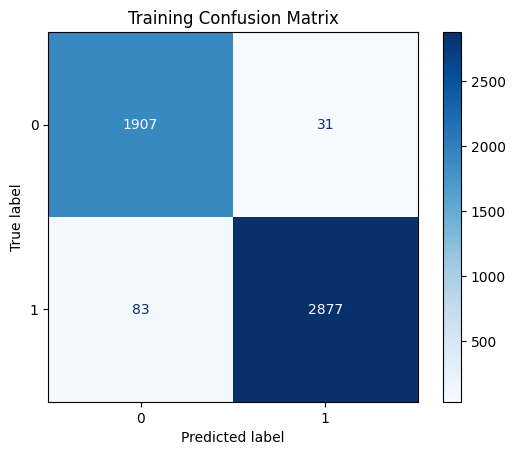

<Figure size 800x600 with 0 Axes>

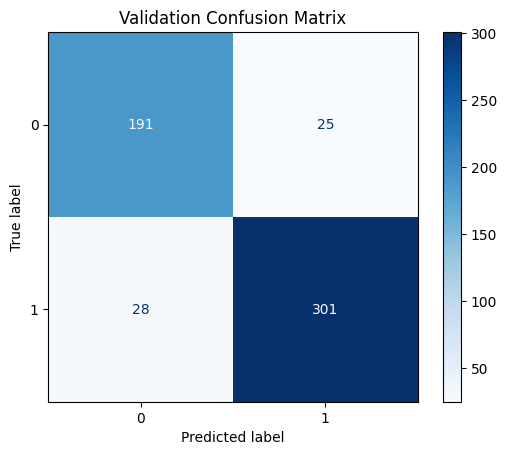

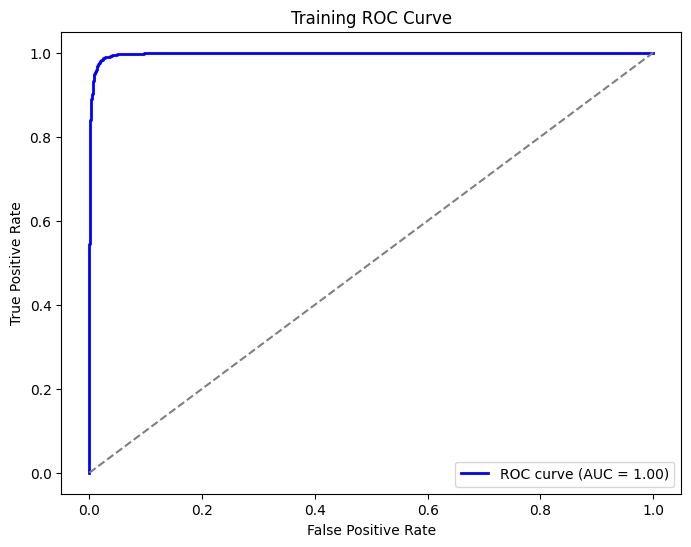

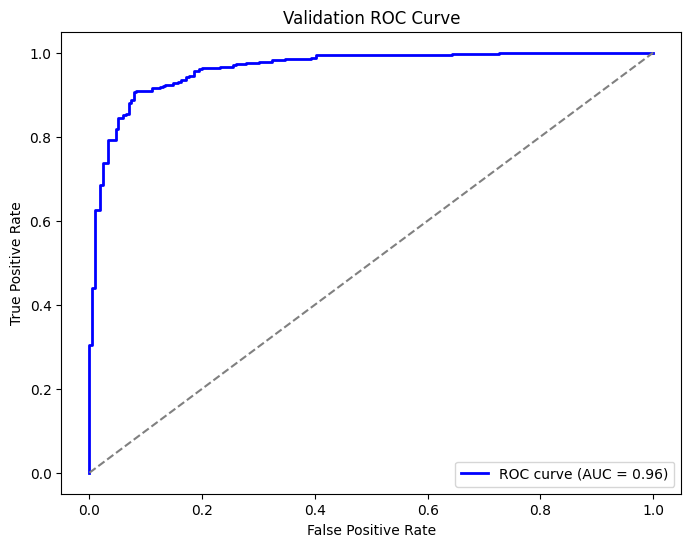

In [96]:
def load_and_evaluate_model(checkpoint_path, train_loader, val_loader, num_classes=2, device='cuda'):
    """
    Load ResNet model from checkpoint and evaluate it
    """
    
    model = models.resnet18(weights=None)
    
    
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
    
    
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    elif 'state_dict' in checkpoint:
        model.load_state_dict(checkpoint['state_dict'])
    else:
        
        model.load_state_dict(checkpoint)
    
    
    model = model.to(device)
    model.eval()
    
    
    def collect_predictions(loader):
        y_true, y_pred, y_scores = [], [], []
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                scores = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)
                
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
                y_scores.extend(scores.cpu().numpy())
        return np.array(y_true), np.array(y_pred), np.array(y_scores)
    
    
    print("Collecting training predictions...")
    y_true_train, y_pred_train, y_scores_train = collect_predictions(train_loader)
    print("Collecting validation predictions...")
    y_true_val, y_pred_val, y_scores_val = collect_predictions(val_loader)
    
    
    def calculate_metrics(y_true, y_pred):
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
        conf_matrix = confusion_matrix(y_true, y_pred)
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': conf_matrix
        }
    
    
    train_metrics = calculate_metrics(y_true_train, y_pred_train)
    val_metrics = calculate_metrics(y_true_val, y_pred_val)
    
    print("\nTraining Metrics:")
    print(f"Accuracy: {train_metrics['accuracy']:.4f}")
    print(f"Precision: {train_metrics['precision']:.4f}")
    print(f"Recall: {train_metrics['recall']:.4f}")
    print(f"F1-Score: {train_metrics['f1']:.4f}")
    
    print("\nValidation Metrics:")
    print(f"Accuracy: {val_metrics['accuracy']:.4f}")
    print(f"Precision: {val_metrics['precision']:.4f}")
    print(f"Recall: {val_metrics['recall']:.4f}")
    print(f"F1-Score: {val_metrics['f1']:.4f}")
    
    
    def plot_confusion_matrix(conf_matrix, title):
        plt.figure(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
        disp.plot(cmap='Blues')
        plt.title(title)
        plt.show()
    
    plot_confusion_matrix(train_metrics['confusion_matrix'], 'Training Confusion Matrix')
    plot_confusion_matrix(val_metrics['confusion_matrix'], 'Validation Confusion Matrix')
    
    
    if y_scores_train.shape[1] == 2:  
        def plot_roc_curve(y_true, y_scores, title):
            fpr, tpr, _ = roc_curve(y_true, y_scores[:, 1])  
            roc_auc = auc(fpr, tpr)
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(title)
            plt.legend(loc='lower right')
            plt.show()
            return roc_auc
        
        train_auc = plot_roc_curve(y_true_train, y_scores_train, 'Training ROC Curve')
        val_auc = plot_roc_curve(y_true_val, y_scores_val, 'Validation ROC Curve')
    
    return model, train_metrics, val_metrics



checkpoint_path = 'Models/ResNet18.pth.tar'


model, train_metrics, val_metrics = load_and_evaluate_model(
    checkpoint_path=checkpoint_path,
    train_loader=train_loader,
    val_loader=val_loader,
    num_classes=2,  
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
